# Radiography analysis : Oxygen flow segmentation
> Created 21 January 2025 by FM Chabot

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from PIL import Image
import tomopy
import dxchange
from skimage import filters
from skimage import morphology
from skimage.transform import rescale
from skimage.restoration import denoise_nl_means, estimate_sigma

In [25]:
path = os.path.dirname(os.path.realpath('Radiography'))
inputPath = os.path.join(path, '1- RawRadiography/')
outputPath = os.path.join(path, '2- FilteredRadiography/')

exp_time = 5 #ms
x_middle = 0.5 #Float from 0 to 1, to determine the x middle pixel number
print(path)

C:\Users\flori\OneDrive - UC Irvine\Documents\Beamtimes\240517 - MicroCT\1- ManualCounts\Notebook - Github


## Calculating background
---
> ### Focus on right channel only 

In [71]:
#Creating the background image from darker images 
bcgndFolder = "4- Background"
framesNumber = 5  #number of frames used to create the background

#Folder path specifications and list of files name
dataPath = os.path.join(path, bcgndFolder)
bcgndFile =os.path.join(dataPath,'Background.tiff')
filenamelist = os.listdir(inputPath)
filenamelist.sort()
try:
    filenamelist.remove('.ipynb_checkpoints')
except ValueError:
    pass  # do nothing!
print('Files:',filenamelist[0],',... ,', filenamelist[-1])

#Asserts if the background image exists already
if not os.path.exists(bcgndFile):
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    bcgnd = np.array(Image.open(inputPath + '/' + filenamelist[0]), dtype=np.float32, copy=False)

    x_middle_pix = int(np.round((np.shape(bcgnd)[1]-1)*x_middle,0))
    print('Middle pixel is', x_middle_pix)
    
#Calculate background
    #Make a dataframe of the average intensity of every projections (right channel)
    right_Iavg = []
    for i in filenamelist[:]:
        im = Image.open(inputPath+'/'+i)
        im = np.array(im, dtype=np.float32, copy=False)
        right_Iavg.append(np.mean(im[:, x_middle_pix+300:]))
    df = pd.DataFrame({'right_Iavg':right_Iavg})
    #Index corresponding to the darkest image 
    ind_bcgnd_right = df[1:].nsmallest(framesNumber,'right_Iavg').index
        
    #Compute right background
    right_bcgnd = Image.open(inputPath+'/'+filenamelist[ind_bcgnd_right[0]])
    right_bcgnd = np.array(right_bcgnd, dtype=np.float32, copy=False)[:, x_middle_pix:]
    print('Background image:', filenamelist[ind_bcgnd_right[0]])
    for r in ind_bcgnd_right[1:]:
        print('Background image:', filenamelist[r])
        im = Image.open(inputPath+'/'+filenamelist[r])
        im = np.array(im, dtype=np.float32, copy=False)[:, x_middle_pix:]
        right_bcgnd = right_bcgnd+im
    right_bcgnd = right_bcgnd/framesNumber

    #Display and save the background created as a transmission image
    ax.imshow(right_bcgnd)
    ax.set_title('Background - Right')
    right_bcgnd = Image.fromarray(right_bcgnd)
    right_bcgnd.save(bcgndFile)
    print('Background average file created:', bcgndFile)
    
else:
    print('Brackground file already exists:', bcgndFile)

Files: 88psi_wdw1_000.tif ,... , 88psi_wdw1_025.tif
Brackground file already exists: C:\Users\flori\OneDrive - UC Irvine\Documents\Beamtimes\240517 - MicroCT\1- ManualCounts\Notebook - Github\4- Background\Background.tiff


## Images filtering
---
>Testing background subtraction and filtering process on one image
> ### Subtract background

Text(0.5, 1.0, 'Measurement - Background')

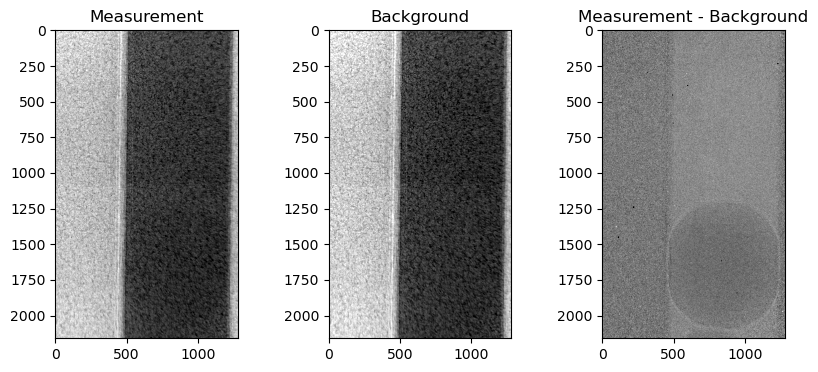

In [29]:
#Import background and convert into attenuation
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
projNum = 2 #index of the image used 

filenamelist.sort()

#Import image
im = np.array(Image.open(inputPath+'/'+filenamelist[projNum]))
x_middle_pix = int(np.round((np.shape(im)[1]-1)*x_middle,0))
#Subtract background from attenuation images
im = -np.log(im[:, x_middle_pix:])    
bcgnd = np.array(Image.open(bcgndFile))
bcgnd = -np.log(bcgnd)
subIm = im-bcgnd

#Display background correction
ax[0].imshow(im, cmap='gray', vmin=np.quantile(im, 0.02), vmax=np.quantile(im, 0.98))
ax[0].set_title('Measurement')
ax[1].imshow(bcgnd, cmap='gray', vmin=np.quantile(bcgnd, 0.02), vmax=np.quantile(bcgnd, 0.98))
ax[1].set_title('Background')
ax[2].imshow(subIm, cmap='gray', vmin=np.quantile(subIm, 0.04), vmax=np.quantile(subIm, 0.96))
ax[2].set_title('Measurement - Background')

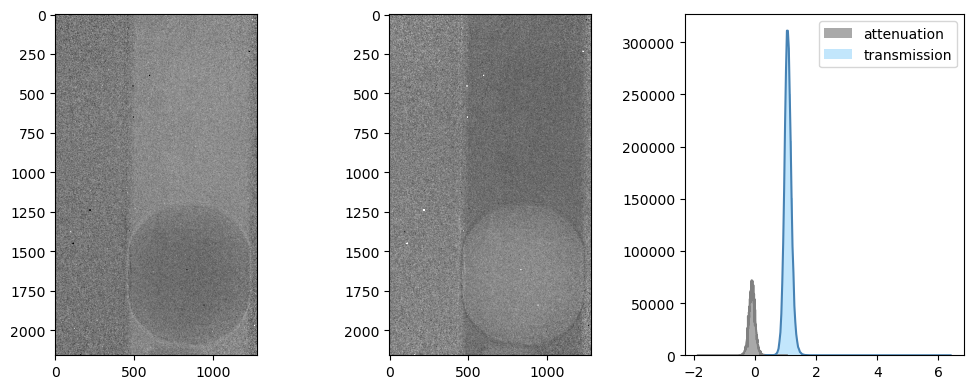

In [31]:
#Execute the cell above before this one
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

#Calculte the transmission image
counts_att, bins_att = np.histogram(subIm, bins=500)
ax[0].imshow(subIm, cmap='gray', vmin=np.quantile(subIm, 0.04), vmax=np.quantile(subIm, 0.96))
subIm = np.exp(-subIm) 

#Remove outliers
im = tomopy.remove_outlier(subIm, 0.1, size=5, axis=0) # ← To tune to remove bright spots  
ax[1].imshow(subIm, cmap='gray', vmin=np.quantile(subIm, 0.04), vmax=np.quantile(subIm, 0.96))

#Display attenuation and transmission images
counts_tr, bins_tr = np.histogram(subIm, bins=200)
ax[2].hist(bins_att[:-1], bins_att[:], weights=counts_att[:], color='darkgrey', label='attenuation')
ax[2].plot(bins_att[:-1], counts_att[:], color='grey')
ax[2].hist(bins_tr[:-1], bins_tr[:], weights=counts_tr[:], color='lightskyblue', label='transmission', alpha=0.5)
ax[2].plot(bins_tr[:-1], counts_tr[:], color='steelblue')
ax[2].legend()
fig.tight_layout()

> ### Downsampling and filtering 

Sigma denoising:   5.29E-02


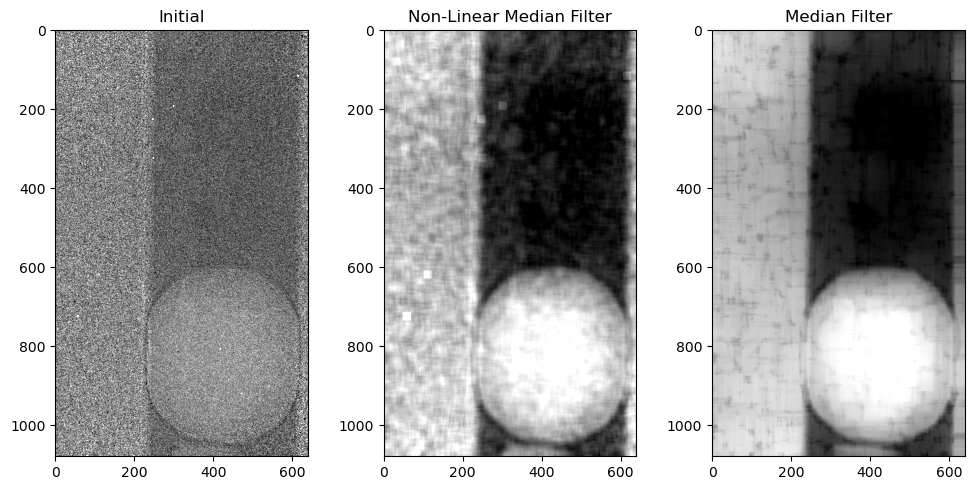

In [54]:
#Apply non linear median filter and median filter
#Parameters to tune:
diff_outlier, size_outlier = 0.0001, 100 #Remove outlier parameters
path_size, patch_distance, h = 5, 10, 1 #Denoising parameters
down_sample = 0.5 #Downsampling factor

fig, ax = plt.subplots(1,3,figsize=(10,5))
#Downsampling
im = rescale(subIm, down_sample, anti_aliasing=False)
ax[0].imshow(im, cmap='gray', vmin=np.quantile(im, 0.04), vmax=np.quantile(im, 0.96))
ax[0].set_title('Initial')

#Denoising non linear median filter
sigma = np.mean(estimate_sigma(im))
print('Sigma denoising:', "%10.2E" % sigma)
im = denoise_nl_means(im, patch_size=path_size, patch_distance=patch_distance, h=h, fast_mode=True, sigma=sigma, 
                          preserve_range=True, channel_axis=None)
ax[1].imshow(im, cmap='gray', vmin=np.quantile(im, 0.04), vmax=np.quantile(im, 0.96))
ax[1].set_title('Non-Linear Median Filter')

#Median Filter
im = tomopy.remove_outlier(im, diff_outlier, size=size_outlier, axis=0)
im = tomopy.remove_outlier(im, diff_outlier, size=size_outlier, axis=1)
ax[2].imshow(im, cmap='gray', vmin=np.quantile(im, 0.04), vmax=np.quantile(im, 0.96)) 
ax[2].set_title('Median Filter')
fig.tight_layout()

### Apply filtering to all images
> Use parameter defined previously

In [69]:
fil_dataFolder = '2- FilteredRadiography/'
OutputPath = os.path.join(path, fil_dataFolder)

print('Output path:', OutputPath)

Output path: C:\Users\flori\OneDrive - UC Irvine\Documents\Beamtimes\240517 - MicroCT\1- ManualCounts\Notebook - Github\2- FilteredRadiography/


In [73]:
#Import background image and convert it into an attenuation image
bcgnd = Image.open(bcgndFile)
bcgnd = np.array(bcgnd, dtype=np.float32, copy=False)
bcgnd_att = -np.log(bcgnd)

#Sequential image process
radios = []
for i in filenamelist[:]: #Change the number of radios to processed
    print(i)
    im = np.array(Image.open(inputPath+'/'+i))[:, x_middle_pix:]
    #Background subtraction
    im_att = -np.log(im)
    im_att = im_att - bcgnd_att
    im = np.exp(-im_att)
    
    #Downsampling
    im = rescale(im, 0.5, anti_aliasing=False)
    
    #Noise filter : non linear filter
    sigma = np.mean(estimate_sigma(im))
    im = denoise_nl_means(im, patch_size=path_size, patch_distance=patch_distance, h=h, fast_mode=True, sigma=sigma, 
                              preserve_range=True, channel_axis=None)
    
    #Median filters
    im = tomopy.remove_outlier(im, diff_outlier, size=size_outlier, axis=0)
    im = tomopy.remove_outlier(im, diff_outlier, size=size_outlier, axis=1)

    #Saving image
    im = Image.fromarray(im)
    im.save(OutputPath + str(i))

print('Filter applied and image saved in:', OutputPath)

88psi_wdw1_000.tif
88psi_wdw1_001.tif
88psi_wdw1_002.tif
88psi_wdw1_003.tif
88psi_wdw1_004.tif
88psi_wdw1_005.tif
88psi_wdw1_006.tif
88psi_wdw1_007.tif
88psi_wdw1_008.tif
88psi_wdw1_009.tif
88psi_wdw1_010.tif
88psi_wdw1_011.tif
88psi_wdw1_012.tif
88psi_wdw1_013.tif
88psi_wdw1_014.tif
88psi_wdw1_015.tif
88psi_wdw1_016.tif
88psi_wdw1_017.tif
88psi_wdw1_018.tif
88psi_wdw1_019.tif
88psi_wdw1_020.tif
88psi_wdw1_021.tif
88psi_wdw1_022.tif
88psi_wdw1_023.tif
88psi_wdw1_024.tif
88psi_wdw1_025.tif
Filter applied and image saved in: C:\Users\flori\OneDrive - UC Irvine\Documents\Beamtimes\240517 - MicroCT\1- ManualCounts\Notebook - Github\2- FilteredRadiography/


## Thresholding and segmentation
---

In [79]:
import time
from skimage import measure
from skimage import morphology
from skimage.filters import (try_all_threshold, threshold_yen, threshold_mean, threshold_multiotsu, 
                             threshold_otsu, threshold_minimum, threshold_li, threshold_isodata,)
from skimage.segmentation import (morphological_chan_vese, morphological_geodesic_active_contour,
                                  checkerboard_level_set, clear_border)

> ### Define channels sizes and threshold method on one image

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

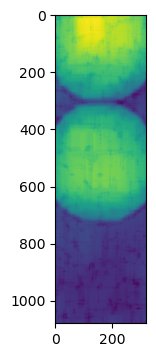

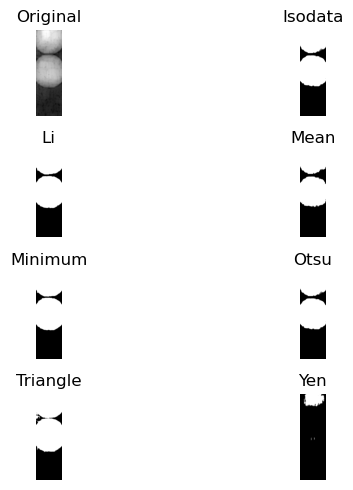

In [81]:
#Run to try all tresholds
indImg = 7 #Image index of the image 
#Minimize the image size to the channel
x_right, y_right = [265, 585], [0, 1080]   

imgNameList_R = os.listdir(OutputPath)
imgNameList_R.sort()
try:
    imgNameList_R.remove('.ipynb_checkpoints')
except ValueError:
    pass  # do nothing!

fig, ax = plt.subplots(1,1, figsize=(4,4))  

imgName_R = imgNameList_R[indImg]
img_R = np.array(Image.open(OutputPath + imgName_R))     
img_R = np.array(img_R)[y_right[0]:y_right[1], x_right[0]:x_right[1]]
ax.imshow(img_R)
try_all_threshold(img_R)

> ### Segmentation

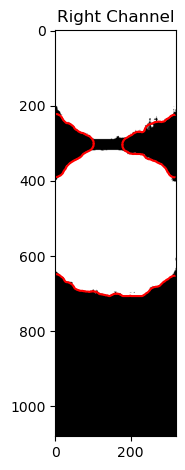

In [90]:
#Define thresholding method
thresh_r = threshold_otsu(img_R) #To define
closingPix = 20
fig, ax = plt.subplots(1, 1)

#Thresholding
rad_right = img_R > thresh_r                           #Use for well defined bubbles
# rad_right = np.clip(img_R, a_min=thresh_r, a_max=5)  #Use for diffuse bubbles

#Contour finding
init_ls_right = checkerboard_level_set(rad_right.shape, 6)
ls_right = morphological_chan_vese(rad_right, num_iter=35, init_level_set=init_ls_right, smoothing=4)

#Closing contour
ls_right = morphology.closing(ls_right, morphology.disk(closingPix))

ax.imshow(rad_right, cmap="gray")
ax.contour(ls_right, [0.5], colors='r')
ax.set_title('Right Channel')
fig.tight_layout()

> ### Label and measure

Number of regions: 1
Number of regions: 3


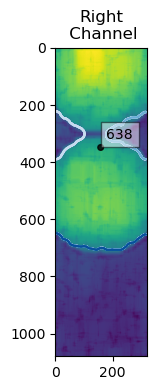

In [92]:
#Measure region properties
from matplotlib.patches import Circle
from skimage.morphology import area_closing
fig, ax = plt.subplots(1, 1, figsize=(5,4), sharey=True)

ax.imshow(img_R)
ax.set_title('Right\n Channel')

for j in [0, 1]: 
    label, num = measure.label(ls_right, background=j, return_num=True) #Change background from 1 to 0 to invert the label regions
    regions = measure.regionprops(label, intensity_image=img_R)
    ax.contour(label, cmap = 'Blues')
    print('Number of regions:', num)
    for props in regions:
        pixelInt = props.intensity_mean
        diameter = props.equivalent_diameter_area
        if diameter > 20:
            area = props.area
            y, x = props.centroid
            circ = Circle((x, y), 10, color='black', fill=True, alpha=0.8)
            if pixelInt>thresh_r:
                ax.add_patch(circ)
                ax.text(x+20, y-30, "%.0f" % float(diameter*1.27), bbox = dict(facecolor='white', alpha=0.5)) #Print bubble equivalent diameter in micron
fig.tight_layout()           

### Sequential image processing - Segment and label
-----

In [96]:
seg_dataFolder = '3- SegmentedResults'
dataPath = os.path.join(path, fil_dataFolder)
OutputFolder = os.path.join(path, seg_dataFolder)

print('Output:', OutputFolder)

Output: C:\Users\flori\OneDrive - UC Irvine\Documents\Beamtimes\240517 - MicroCT\1- ManualCounts\Notebook - Github\3- SegmentedResults


In [ ]:
firstFile = 0 #First file to segment

d = {'frameNumber':[],
     'labelNumber':[],
     'Channel':[],
     'avgIntensity':[],
     'Area':[],
     'Equ_diameter':[],
     'center_x':[],
     'center_y':[]}

data = pd.DataFrame(d)
classfile = os.path.join(path, 'Classification.txt')
df_class = pd.read_csv(classfile, sep='\t', index_col=0)
r=0
for i in imgNameList_R[firstFile:]:
    if df_class[df_class.columns[0]][r] == 'y':
        frameN = int(i[-7:-4])
        print(frameN, ':', i)
        
        im = np.array(Image.open(dataPath + '/' + i))
        fig, ax = plt.subplots(1,1 , sharey=True)
        
        im = im[y_right[0]:y_right[1], x_right[0]:x_right[1]]
        im = morphology.closing(im, morphology.disk(closingPix))
        im_init = im
        
        try: 
            thresh = threshold_otsu(im)  #Modify threshold algorithm depending on images
        except:
            pass
            
        im = im > thresh                            #Use for well defined bubbles
        # im = np.clip(im, a_min=thresh, a_max=5)   #Use for diffuse bubbles
    
        #Creating the contour
        init_ls = checkerboard_level_set(im.shape, 6)
        ls = morphological_chan_vese(im, num_iter=35, init_level_set=init_ls, smoothing=5)
        ls = morphology.closing(ls, morphology.disk(closingPix))
    
        ax.imshow(im_init, cmap='gray')
        ax.contour(ls, colors='r') 
    
        #Labelling regions      
        for j in [0, 1]:
            label = measure.label(ls, background=j)
            regions = measure.regionprops(label, intensity_image=im_init)
            for props in regions:
                pixelInt = props.intensity_mean
                diameter = props.equivalent_diameter_area
                if diameter > 20:
                    if pixelInt > thresh:
                        area = props.area
                        labelNum = props.label
                        y1, x1 = props.centroid
                        circ = Circle((x1, y1), 10, color='black', fill=True, alpha=0.8)
                        ax.add_patch(circ)
                        ax.text(x1+20, y1-30, "%.0f" % float(diameter), bbox = dict(facecolor='white', alpha=0.5))
    
                        data.loc[len(data.index)] = [frameN, labelNum, 1, pixelInt, area, diameter, x1, y1]
    
        fig.tight_layout()
        fig.savefig(OutputFolder+'/'+i)
        plt.close()
        
        data.reset_index(drop=True)
        data.to_csv(OutputFolder + '/' + i[:-8] + '.txt', index=False)
    else:
        print(frameN, ':', i, '- No oxygen')
    r = r+1
print('----------------------','Done','----------------------')

0 : 88psi_wdw1_000.tif
1 : 88psi_wdw1_001.tif
2 : 88psi_wdw1_002.tif
3 : 88psi_wdw1_003.tif
4 : 88psi_wdw1_004.tif
5 : 88psi_wdw1_005.tif
6 : 88psi_wdw1_006.tif
7 : 88psi_wdw1_007.tif
8 : 88psi_wdw1_008.tif
9 : 88psi_wdw1_009.tif
10 : 88psi_wdw1_010.tif
11 : 88psi_wdw1_011.tif
12 : 88psi_wdw1_012.tif
